# STILL NONSENSE TESTING - IGNORE 

In [1]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from braincoder.utils.visualize import *
%matplotlib inline

# Simulate data

In [2]:
import prfpy_csenf
import os 
from os.path import join as opj
seq_path = os.path.join(os.path.dirname(prfpy_csenf.__path__[0]))
sfs_seq = np.load(opj(seq_path, 'eg_sfs_seq.npy'))
# sfs_seq = np.append(sfs_seq, np.zeros(500))

con_seq = np.load(opj(seq_path, 'eg_con_seq.npy'))
# con_seq = np.append(con_seq, np.zeros(500))
paradigm = np.vstack([sfs_seq, con_seq])


In [3]:
# Stimulus object 
from braincoder.stimuli import ContrastSensitivityStimulus
cs_stim = ContrastSensitivityStimulus()

In [4]:
bounds = {
    'width_r'  : [0,1.5],          
    'SFp'       : [0, 6],
    'CSp'       : [0, 200] ,
    'width_l'   : [0.65, 0.69],     # we fix width_l in our model
    'crf_exp'   : [0, 10] ,
    'amplitude' : [0, 10],       # Amplitude of TC
    'baseline'  : [-.1,.1]
}
n_vx = 100
parameters = pd.DataFrame({
    key:np.random.uniform(bounds[key][0], bounds[key][1], n_vx) for key in bounds
}).astype('float32')

n_vx = parameters.shape[0]
idx_cols = sns.color_palette("hsv", n_vx)

In [5]:
from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel

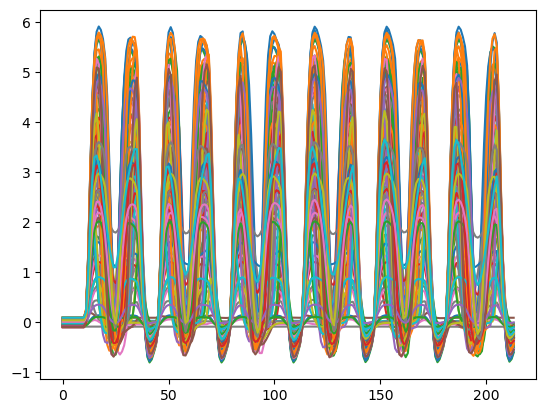

In [6]:
model = ContrastSensitivityWithHRF(
    parameters=parameters,
    SF_seq=sfs_seq,  
    CON_seq=con_seq,       
    hrf_model=SPMHRFModel(tr=1.5),

)
pred = model.predict()
plt.plot(pred)

# Classic fitter

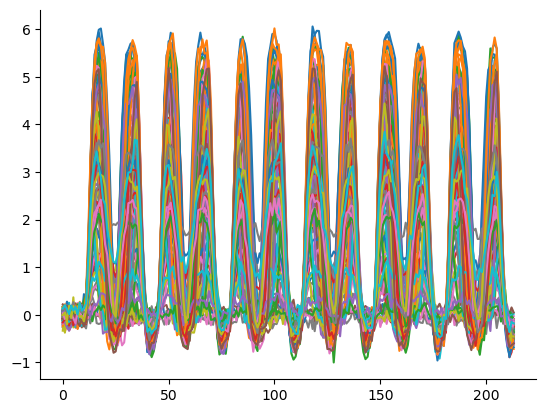

In [7]:

data = model.simulate(noise=.1)
data.plot(legend=False)
sns.despine()
    

In [8]:
from braincoder.bprf_mcmc import *
from braincoder.optimize import ParameterFitter
cfitter = ParameterFitter(model, data, model.paradigm)
grid_pars = cfitter.fit_grid(
    width_r=np.linspace(0, 3, 10),
    SFp=np.linspace(0, 6, 10),
    CSp=np.linspace(50, 200, 10),
    width_l=[0.68],
    crf_exp=np.linspace(1, 5, 10),    
    baseline=[0.0],
    amplitude=[1.0],
    use_correlation_cost=True
    )
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars, ) #fixed_pars={'width_l' : 0.68})

/Users/marcusdaghlian/miniforge3/envs/braincoder/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Working with chunk size of 5192
Using correlation cost!


100%|██████████| 2/2 [00:00<00:00,  4.70it/s]
/Users/marcusdaghlian/programs/braincoder_bprf/braincoder/optimize.py:420: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[9.10366249e+00 6.33119869e+00 6.92862320e+00 2.49353600e+00
 7.87581444e+00 6.44464159e+00 5.58602476e+00 3.30222584e-02
 5.90850687e+00 7.34449720e+00 1.49683785e+00 7.50232887e+00
 7.67525959e+00 6.41564369e+00 4.58848572e+00 7.34236431e+00
 5.11409473e+00 1.30480540e+00 5.92670250e+00 4.33612347e+00
 8.19879818e+00 4.77730942e+00 3.89989519e+00 7.41091490e+00
 3.14470768e+00 6.14190722e+00 7.53972483e+00 6.71202064e-01
 5.41239548e+00 1.88199174e+00 2.99094975e-01 8.33665562e+00
 2.83377886e+00 6.46658516e+00 4.66543865e+00 1.00000000e-04
 5.27039003e+00 1.00000000e-04 5.52191448e+00 5.47266531e+00
 3.96267653e+00 3.03708506e+00 9.03315163e+00 5.68256807e+00
 3.67741632e+00 7.75913429e+00 1.68650910e-01 1.00000000e-04
 1.00000000e-04 6.

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 100


Current R2: nan/Best R2: 0.87865: 100%|██████████| 1000/1000 [00:06<00:00, 143.08it/s]


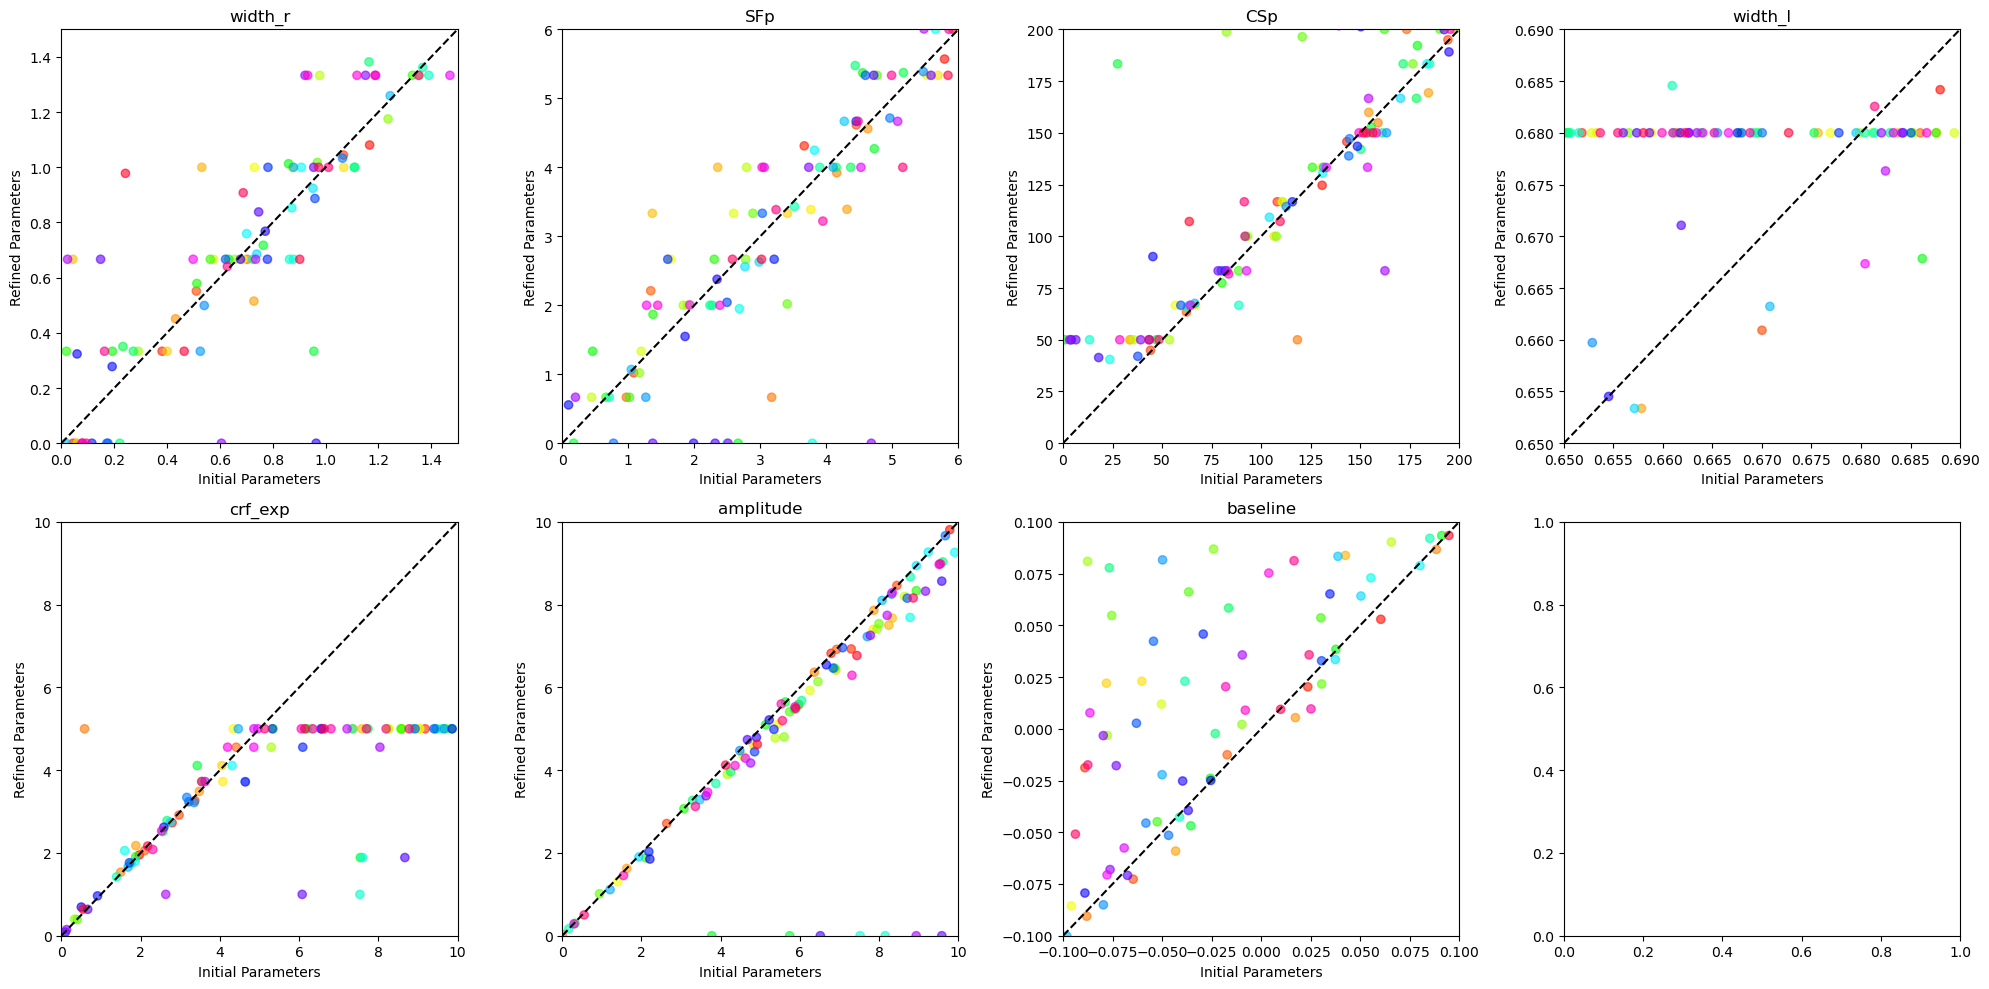

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
param_names = parameters.columns

for i, param in enumerate(param_names):
    ax = axs[i]
    ax.scatter(parameters[param], refined_pars[param], c=idx_cols, alpha=0.6)
    ax.set_title(param)
    ax.set_xlabel('Initial Parameters')
    ax.set_ylabel('Refined Parameters')
    ax.plot([bounds[param][0], bounds[param][1]], 
            [bounds[param][0], bounds[param][1]], 'k--')
    ax.set_xlim(bounds[param])
    ax.set_ylim(bounds[param])
    # ax.set_aspect('square')

plt.tight_layout()
plt.show()

In [10]:
bfitter = BPRF(model, data)
bfitter.add_priors_from_bounds(
    bounds, 
)
bfitter.prep_for_fitting()


init_pars = {
    'width_r' : np.ones(n_vx) * 1,
    'SFp' : np.ones(n_vx) * 1,
    'CSp' : np.ones(n_vx) * 100,
    'width_l' : np.ones(n_vx) * 0.68,
    'crf_exp' : np.ones(n_vx) * 1,
    'amplitude' : np.ones(n_vx) * 1, 
    'baseline' : np.ones(n_vx) * 0, 
}
init_pars = pd.DataFrame(init_pars)

idx=0
bfitter.fit_all(
    init_pars=init_pars, 
    num_results=100,
)

Lets run some checks with everything...


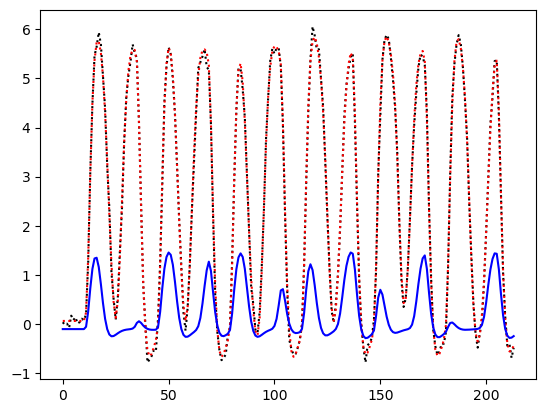

In [11]:
idx = 3
burn_in = 100
plt.plot(data.iloc[:,0], ':k')
plt.plot(pred.iloc[:,0], ':r')
cpred = model.predict(parameters=refined_pars)
plt.plot(cpred.iloc[:,idx], 'b')
# this_pred = bfitter.model.predict(
#     parameters=bfitter.mcmc_sampler[idx]
# )
# plt.plot(
#     this_pred.iloc[:,burn_in:], '-g', alpha=.1,
# )

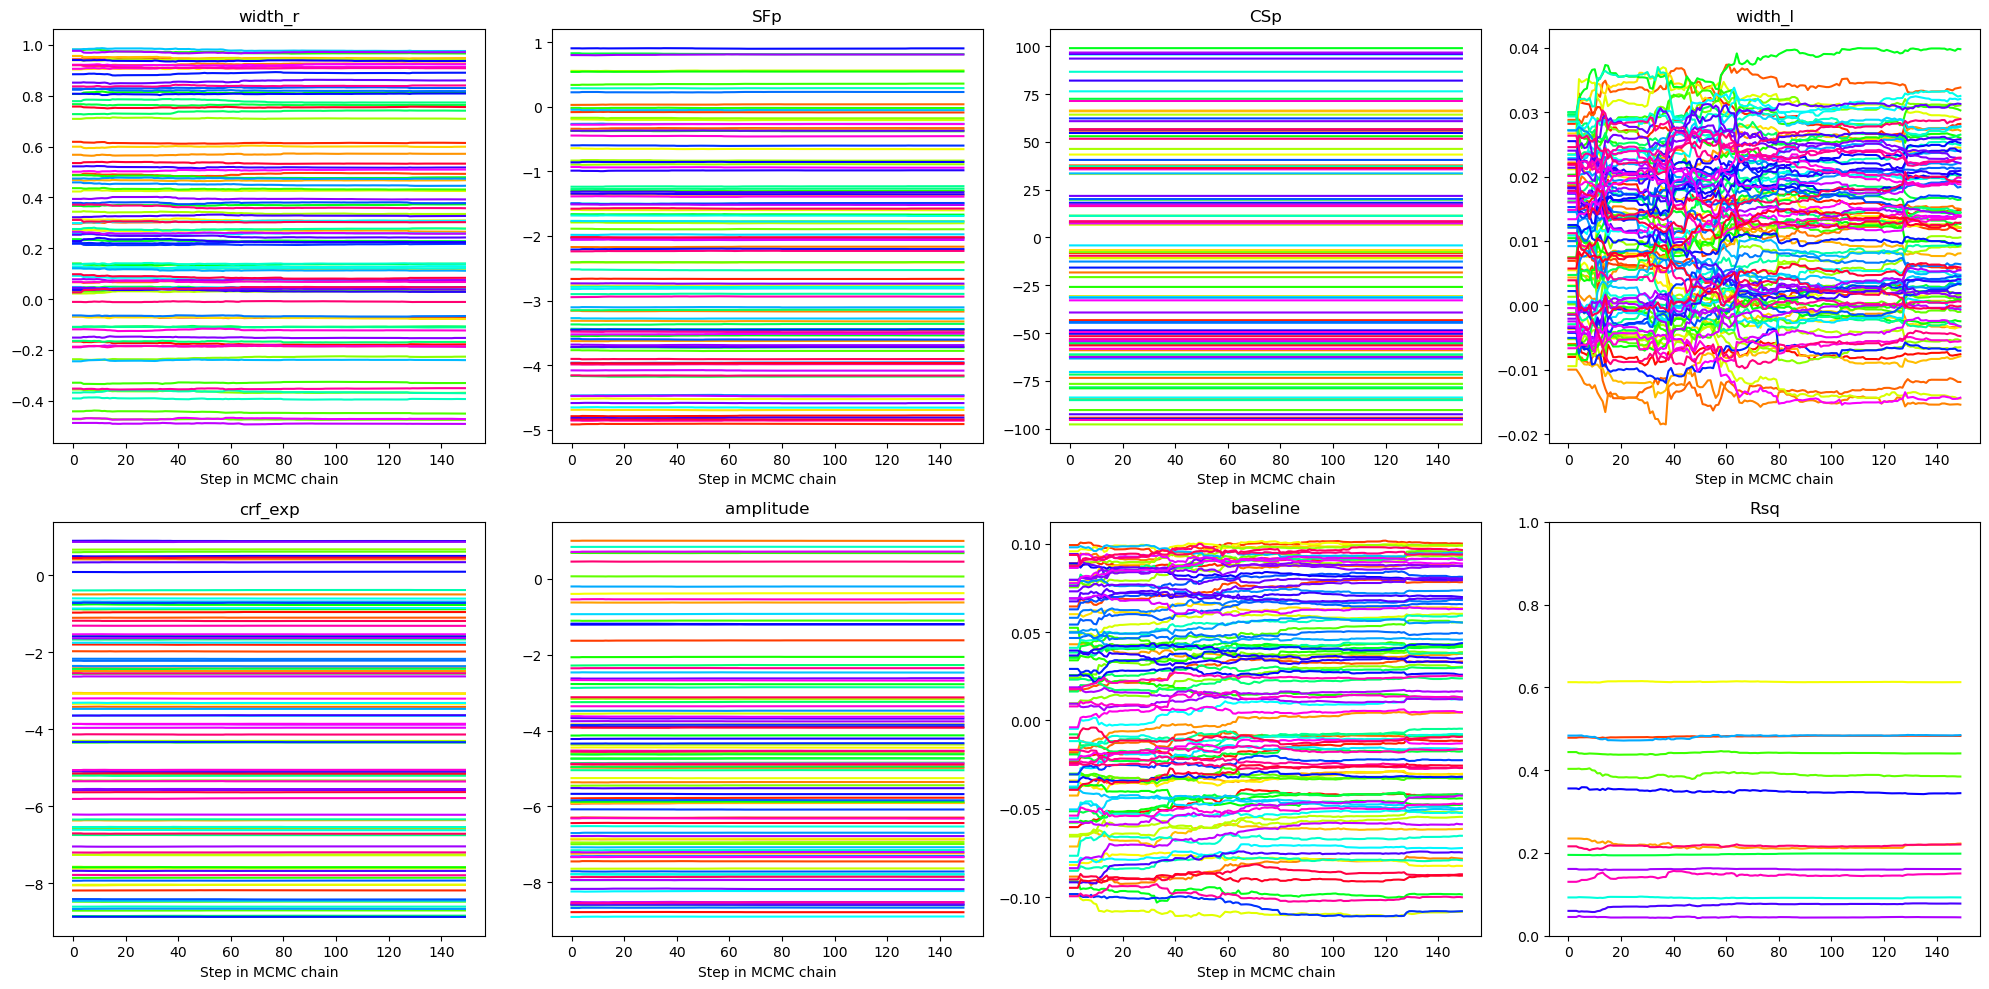

In [20]:
# Lets see are we getting closer?
fig,axs = plt.subplots(2,4,figsize=(20,10))
axs = axs.flatten()
for ip,p in enumerate(bfitter.model_labels):
    ax = axs[ip]
    ax.set_title(p)
    ax.set_xlabel('Step in MCMC chain')
    for i in range(n_vx):
        ax.plot(
            bfitter.mcmc_sampler[i][p] - parameters[p][i],
            color=idx_cols[i],        
            )
        # # Lets add the ground truth
        # ax.axhline(
        #     parameters[p][i], 
        #     color=idx_cols[i],        
        #     linestyle=':'
        # )

ax = axs[-1]
ax.set_title('Rsq')
for i in range(n_vx):
    rsq = bfitter.get_rsq_for_idx(
        idx=i, parameters=bfitter.mcmc_sampler[i],
    )
    plt.plot(
        rsq, 
        color=idx_cols[i]
        ) 
plt.ylim(0,1)
plt.tight_layout()

In [19]:
bfitter.mcmc_sampler[i][p] -  parameters[p][i]

0     -0.166895
1     -0.166895
2     -0.166895
3     -0.166895
4     -0.169540
         ...   
145   -0.178299
146   -0.178266
147   -0.178141
148   -0.178068
149   -0.178135
Name: width_r, Length: 150, dtype: float32

In [ ]:
bfitter.mcmc_sampler[n_vx]

In [ ]:
rsq = fitter.get_rsq_for_idx(
    idx=idx, parameters=fitter.mcmc_sampler[idx],
)

rsq_cols = dag_get_col_vals(
    rsq, cmap='RdBu_r', vmin=-1, vmax=1,
    )
rsq


In [ ]:
plt.plot(rsq)

In [ ]:
pred = fitter.get_predictions(
    parameters=fitter.mcmc_sampler[idx],
    # c=rsq_cols[500:,:]
)
id_start = 540
colors = [tuple(color) for color in rsq_cols[id_start:, :-1]]
plt.plot(
    pred.iloc[:,id_start:],
    # c=colors,
)
plt.plot(data.iloc[:,0])
fitter.mcmc_sampler[idx].iloc[545:546,:]

In [ ]:
idx = 0
burn_in = 100
sns_plot = sns.pairplot(
    fitter.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.

edit_pair_plot(
    sns_plot.axes, 
    lines_dict=parameters.iloc[idx,:].to_dict(), 
    lim_dict=bounds, 
    color='g', linestyle=':', lw=4, label='Truth'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.legend()
plt.show()

In [ ]:
a = fitter.mcmc_sampler[1]
pred = model.predict(parameters=a.iloc[:1,:])

plt.plot(data.iloc[:,0])
plt.plot(pred)

In [ ]:
for p in a.keys():
    plt.figure()
    plt.plot(a[p])
    plt.title(p)

for p in a.keys():
    plt.figure()
    plt.hist(a[p])
    plt.title(p)    

In [24]:
fitter.mcmc_sampler[0]

In [ ]:
import corner as corner
_ = corner.corner(
    fitter.mcmc_sampler[1].iloc[500:,:],# truths=parameters.iloc[0,:].T
    # truths=parameters.iloc[1,:]
)
print(parameters.iloc[1,:])
# corner.overplot_points(
#     plt.gcf(), parameters.iloc[0,:],
# )

In [ ]:
pred = fitter.model.predict(
    parameters=fitter.mcmc_sampler[1].iloc[7483:7484,:]
)
pred.plot()
data.iloc[:,0].plot()

In [ ]:
fitter.mcmc_stats[1]['log_prob'].numpy().argmax()

In [ ]:
parameters.keys()
a.keys()

In [ ]:
parameters

In [ ]:
b = model.predict(parameters=a.iloc[:100,:])
plt.plot(b)
plt.plot(data.iloc[:,0], '--k')

In [ ]:
data.iloc[:,0]

In [ ]:
Code

In [ ]:
pars  = ols_pars.iloc[:,0].to_numpy()
pars = pars[np.newaxis,...]
model.predict(parameters = pars) #ols_pars.iloc[:,:0])

In [93]:
eg1 = a[0].numpy()
eg2 = a[1].numpy()

In [ ]:
plt.plot(eg1[:,0])
plt.plot(eg2[:,0])

In [ ]:
init_pars = model._get_parameters(ols_pars)
model._transform_parameters_backward(init_pars.values.astype(np.float32))
